In [35]:
require 'hdf5'

function get_is_worm(lab)
    return lab:ne(1):cmul(lab:le(4)):int() -- a worm will be 2 (good worm),3(difficult worm),4 (aggregate)
end

function get_nn_tab(data, label)
    local tab = {data = data, label = label}
    function tab:size() 
        return self.data:size(1) 
    end
    
    setmetatable(tab, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
    );
    return tab
end


function _remove_black(img)
    local flat_view = img:view(img:nElement())
    local not_zeros = flat_view:ne(0)
    local valid_pixels = flat_view[not_zeros]
    local median_value = torch.median(valid_pixels)[1]
    flat_view[not_zeros] = valid_pixels-median_value
end



function read_set(filename, set_name)
    local myFile = hdf5.open(filename, 'r')
    local data = myFile:read(set_name .. '_x'):all()
    local label = myFile:read(set_name .. '_y'):all()
    
    ds = data:size()
    local ind = torch.LongStorage({ds[1], 1, ds[2], ds[3]})
    data = data:resize(ind)
    
    for i = 1,data:size(1) do
        _remove_black(data[i])
    end
    
    label = get_is_worm(label) + 1
    
    local data_set = get_nn_tab(data, label)
    myFile:close()

    return data_set
end


function read_set_full(filename, set_name)
    local myFile = hdf5.open(filename, 'r')
    local data = myFile:read(set_name .. '_x'):all()
    local data_full = myFile:read(set_name .. '_full_x'):all()
    local label = myFile:read(set_name .. '_y'):all()
    
    label = torch.cat(label, label, 1)
    data = torch.cat(data, data_full, 1)
    
    -- bad_mask = data:eq(0)
    -- data[bad_mask] = MEDIAN_VAL
    
    ds = data:size()
    local ind = torch.LongStorage({ds[1], 1, ds[2], ds[3]})
    data = data:resize(ind)
    
    local data_set = get_nn_tab(data, label)
    myFile:close()

    return data_set
end

filename = '../sample.hdf5'

all_data = {}
for i, field in pairs({'train', 'test', 'val'}) do
    all_data[field] = read_set(filename, field)
end



print(all_data)

{
  val : 
    {
      data : DoubleTensor - size: 1000x1x80x80
      size : function: 0x0e1cc980
      label : IntTensor - size: 1000
    }
  train : 
    {
      data : DoubleTensor - size: 8051x1x80x80
      size : function: 0x0e366bd0
      label : IntTensor - size: 8051
    }
  test : 
    {
      data : DoubleTensor - size: 1000x1x80x80
      size : function: 0x0e1ecff0
      label : IntTensor - size: 1000
    }
}


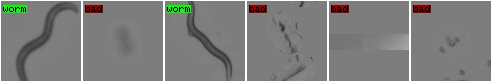

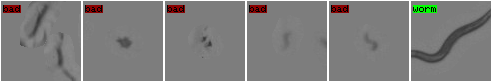

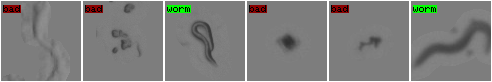

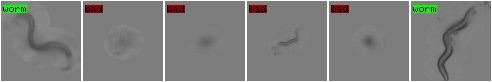

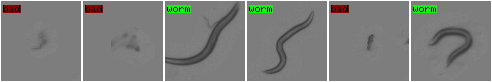

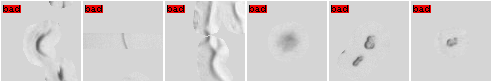

In [2]:
labels_type = {'bad', 'worm', 'worm hard', 'aggregate', 'eggs', 'larvae'}
--self.btn_colors = {1:'darkRed', 2:'green', 3:'yellow', 4:'blue', 5:'magenta', 6:'darkCyan'}
labels_color = {{139,0,0}, {0, 255, 0}, {255,255,0}, {0,0,255}, {255,0,255}, {0,139,139}}
function show_lab_img(t, n_rows)
    local row_size = 6
    local tot_img = t.data and t.data:size(1) or t[1]:size(1)
    local ind = 1
    for i = 1,n_rows do 
        local row = {}
        for n = 1,row_size do
            ind = (i-1)*row_size + n
            
            if ind > tot_img then break end
            
            local img = t.data and t.data[ind] or t[1][ind]
            local lab = t.label and t.label[ind] or t[2][ind]
            
            local col = labels_color[lab]
            
            img = img + 125
            img = torch.repeatTensor(img, 3, 1, 1):type("torch.ByteTensor")
            img = image.drawText(img, labels_type[lab], 2, 4, 
                        {color={0, 0, 0}, bg=col}
                    )
            row[n] = img
        end
        
        if table.getn(row) > 0 then
            itorch.image(row)
        end
        
        if ind > tot_img then break end
    end
end

show_lab_img(all_data['train'], 6)


In [3]:
require 'nn';

net = nn.Sequential()
net:add(nn.SpatialConvolution(1, 6, 5, 5)) -- 1 input image channel, 6 output channels, 5x5 convolution kernel
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*17*17))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
--net:add(nn.Dropout())
net:add(nn.Linear(16*17*17, 300))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.ReLU())                       -- non-linearity 
--net:add(nn.Dropout())
net:add(nn.Linear(300, 50))
net:add(nn.ReLU())                       -- non-linearity 
--net:add(nn.Dropout())
net:add(nn.Linear(50, 2))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                     -- converts the output to a log-probability. Useful for classification problems

print('Lenet5\n' .. net:__tostring());

criterion = nn.ClassNLLCriterion()

trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.001
trainer.maxIteration = 20
trainset = all_data['train']
print(trainset)

timer = torch.Timer()

timer:reset()
trainer:train(trainset)
print('Total training time: ' .. timer:time().real .. ' seconds')


Lenet5
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> output]
  (1): nn.SpatialConvolution(1 -> 6, 5x5)
  (2): nn.ReLU
  (3): nn.SpatialMaxPooling(2,2,2,2)
  (4): nn.SpatialConvolution(6 -> 16, 5x5)
  (5): nn.ReLU
  (6): nn.SpatialMaxPooling(2,2,2,2)
  (7): nn.View(4624)
  (8): nn.Linear(4624 -> 300)
  (9): nn.ReLU
  (10): nn.Linear(300 -> 50)
  (11): nn.ReLU
  (12): nn.Linear(50 -> 2)
  (13): nn.LogSoftMax
}	
{
  data : DoubleTensor - size: 8051x1x80x80
  size : function: 0x0d9e6de8


  label : ByteTensor - size: 8051
}
# StochasticGradient: training	


# current error = 0.12673289444122	


# current error = 0.069699623999031	


# current error = 0.053902541089647	


# current error = 0.038933146984934	


# current error = 0.029475582108156	


# current error = 0.020981468699987	


# current error = 0.019120473103084	


# current error = 0.011677517641824	


# current error = 0.010366174470402	


# current error = 0.0064173165943083	


# current error = 0.0041299098148641	


# current error = 0.0091309806876696	


# current error = 0.0078431511928037	


# current error = 0.01317300001596	


# current error = 0.013090984119458	


# current error = 0.0047974818617886	


# current error = 0.0058570451174421	


# current error = 0.0046157653690378	


# current error = 0.012477518437703	


# current error = 0.0057961839900648	
# StochasticGradient: you have reached the maximum number of iterations	
# training error = 0.0057961839900648	
Total training time: 911.74689793587 seconds	


In [5]:
--[[
require 'clnn'
net_cl = net:cl()
criterion_cl = criterion:cl()
trainset_cl = get_nn_tab(trainset.data:cl(), trainset.label:cl())

trainer_cl = nn.StochasticGradient(net_cl, criterion_cl)
trainer_cl.learningRate = 0.001
trainer_cl.maxIteration = 5 -- just do 5 epochs of training


timer:reset()
trainer_cl:train(trainset_cl)
print('Total training time: ' .. timer:time().real .. ' seconds')
]] 

In [48]:
testset = all_data['val']

tot_samples = testset:size()
local predictions  = net:forward(testset.data):exp()
confidences, predicted_labels = torch.max(predictions, 2)
predicted_labels = torch.squeeze(predicted_labels):int()

real_worms = get_is_worm(testset.label)
predicted_worms = get_is_worm(predicted_labels)



Total number of wrong predictions: 1.7	
Total number of wrong predictions: 1.7	


 1000
[torch.LongStorage of size 1]



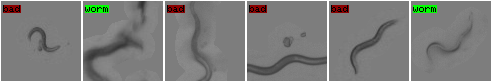

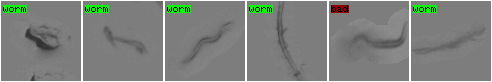

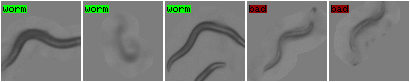

In [49]:
wrong_lab = testset.label:ne(predicted_labels)
wrong = predicted_worms:ne(real_worms)

print('Total number of wrong predictions: ' .. wrong_lab:sum()/tot_samples*100)
print('Total number of wrong predictions: ' .. wrong:sum()/tot_samples*100)

bad_bool_ind = wrong
bad_bool_ind = torch.squeeze(bad_bool_ind)
print(#bad_bool_ind)

bad_ind = {}
for i = 1,bad_bool_ind:size(1) do
    local val = bad_bool_ind[i]
    if val == 1 then
        table.insert(bad_ind, i)
    end
end

local tot_ind = table.getn(bad_ind)
table_reduc = {data = torch.Tensor(tot_ind, 1, 80, 80), label= torch.Tensor(tot_ind)}
for i, ind in pairs(bad_ind) do
    table_reduc.data[i] = testset[ind][1]
    table_reduc.label[i] = predicted_labels[ind]
    --table_reduc.label[i] = dd[2]
end
show_lab_img(table_reduc, 100)

